<a href="https://colab.research.google.com/github/muhammmad-al/decentralized-ai-content-recommender/blob/main/reddit_federated_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
Cloning into 'decentralized-ai-content-recommender'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 9), reused 17 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 507.50 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/decentralized-ai-content-recommender


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  700 non-null    object 
 1   cleaned_text           439 non-null    object 
 2   original_text          449 non-null    object 
 3   score                  700 non-null    int64  
 4   num_comments           700 non-null    int64  
 5   upvote_ratio           700 non-null    float64
 6   timestamp              700 non-null    object 
 7   author                 700 non-null    object 
 8   hashtags               700 non-null    object 
 9   hashtag_count          700 non-null    int64  
 10  text_length            700 non-null    int64  
 11  account_age            699 non-null    float64
 12  author_karma           699 non-null    float64
 13  author_verified        699 non-null    object 
 14  textblob_sentiment     700 non-null    

,title,cleaned_text,original_text,score,num_comments,upvote_ratio,timestamp,author,hashtags,hashtag_count,text_length,account_age,author_karma,author_verified,textblob_sentiment,transformer_sentiment,transformer_score,category
0,"Daily Crypto Discussion - November 9, 2024 (GM...",welcome to the daily crypto discussion thread ...,**Welcome to the Daily Crypto Discussion threa...,8,63,1.00,2024-11-08 19:00:30,CryptoDaily-,"['#Disclaimer', '#Rules', '#Useful']",3,1966,905.0,27705.0,True,0.101466,NEGATIVE,0.999248,ai
1,Deutsche central bank joins Singapore’s Projec...,NaN,NaN,1,2,0.57,2024-11-08 18:26:03,jack-jackson-the2nd,[],0,0,281.0,5143.0,True,0.000000,POSITIVE,0.748121,ai
2,We just surpassed Meta and are back in the Top...,NaN,NaN,23,8,0.83,2024-11-08 17:51:02,CriticalCobraz,[],0,0,207.0,2697.0,True,0.000000,POSITIVE,0.748121,ai
3,Internet Computer and Chainlink Dominate the C...,NaN,NaN,0,13,0.37,2024-11-08 16:55:30,goldyluckinblokchain,[],0,0,1051.0,95577.0,True,0.000000,POSITIVE,0.748121,ai
4,FTX tries to reclaim $11M from Crypto.com-cont...,NaN,NaN,0,5,0.41,2024-11-08 16:43:28,partymsl,[],0,0,1597.0,338078.0,True,0.000000,POSITIVE,0.748121,ai


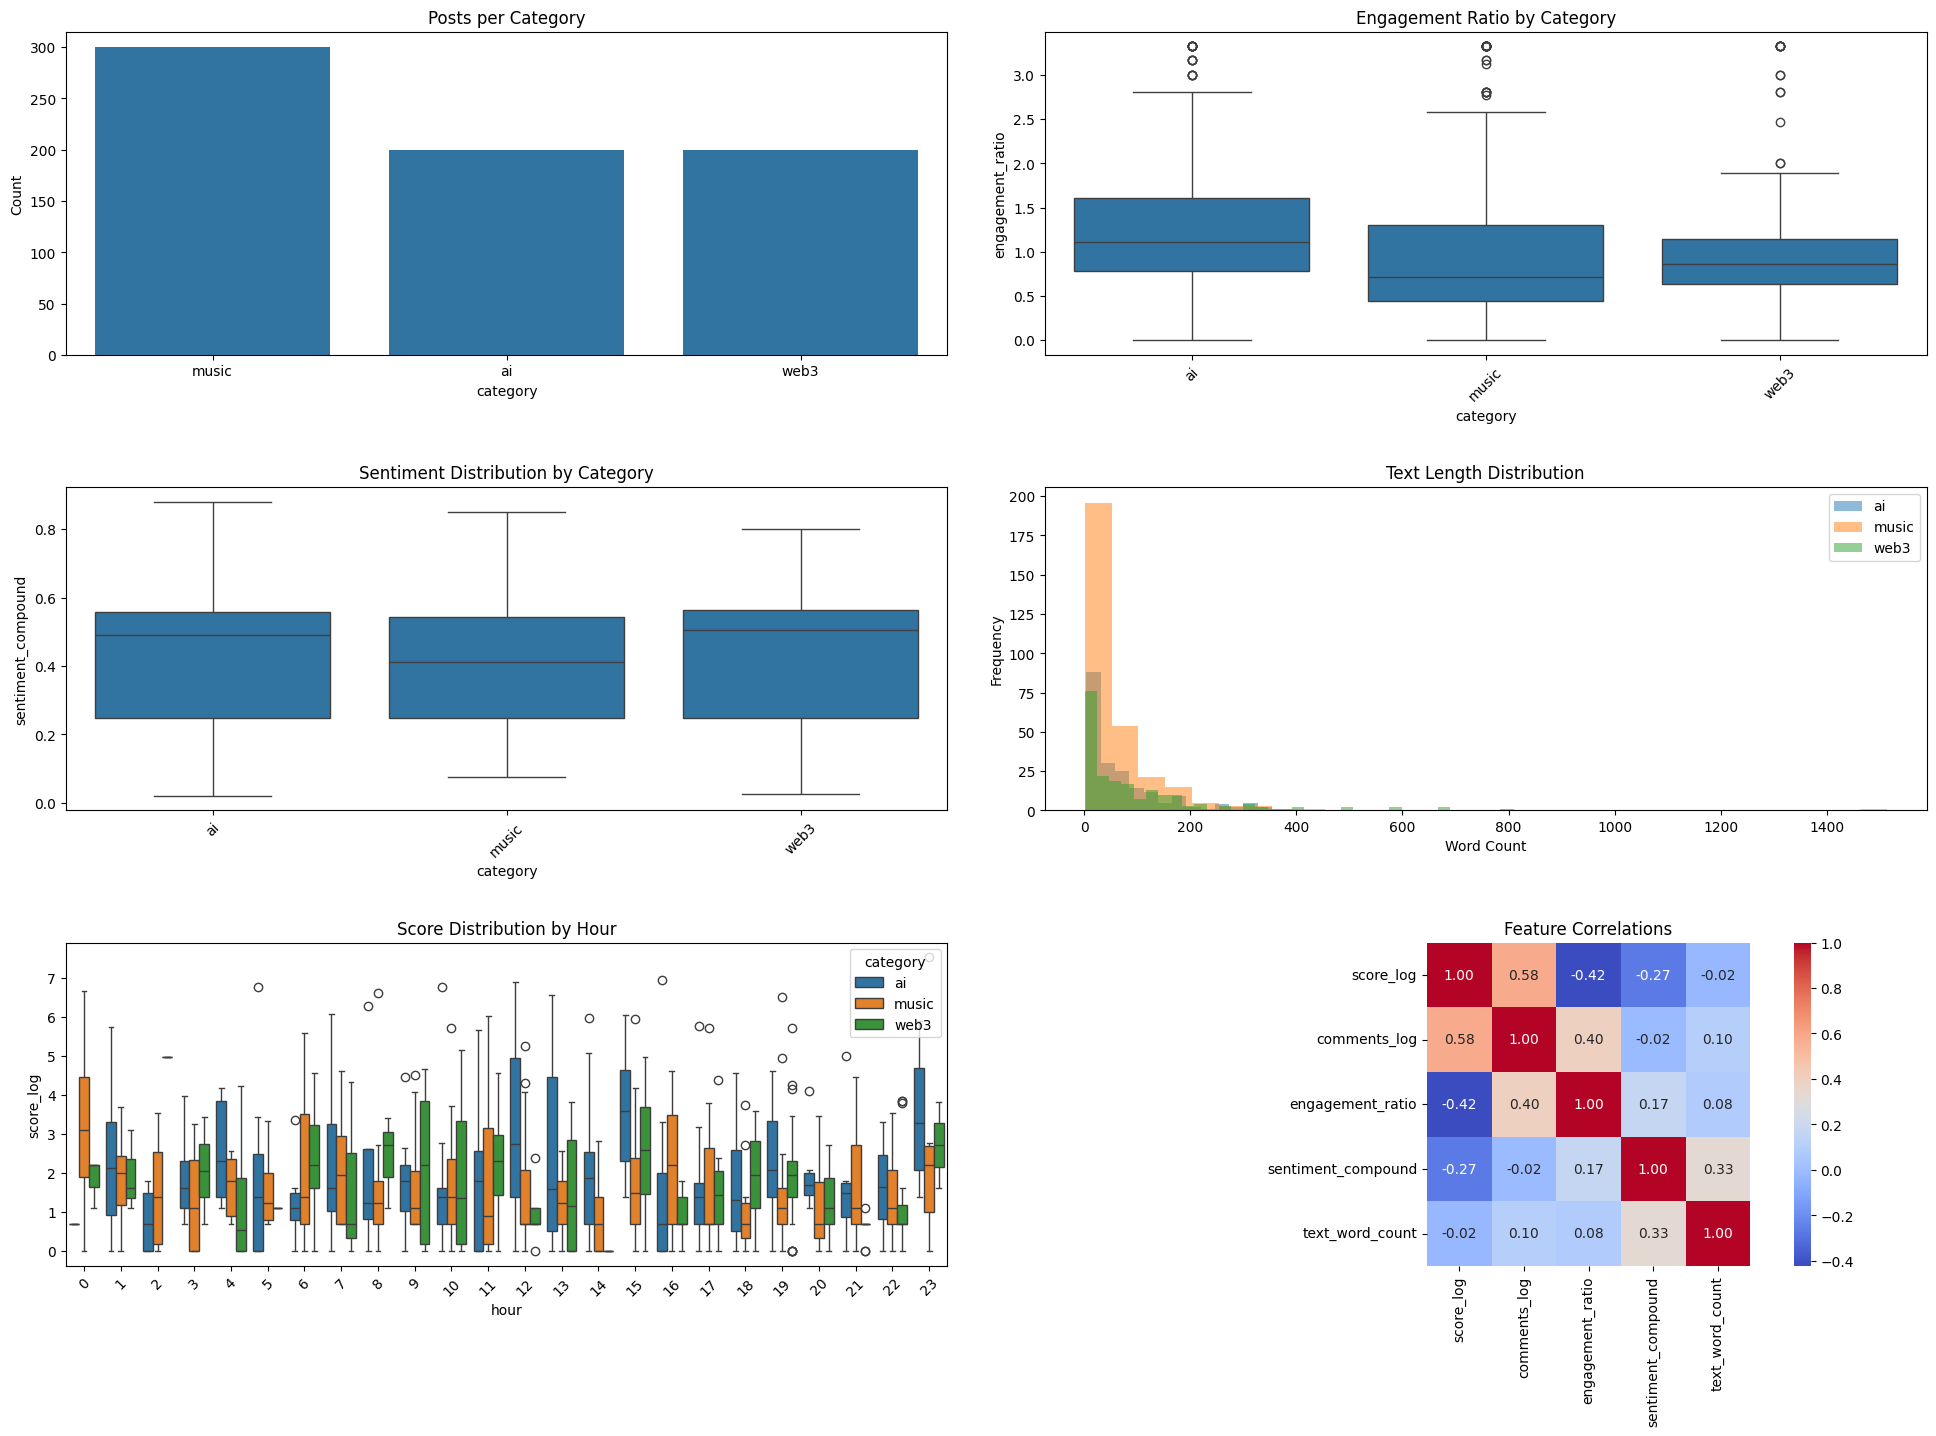

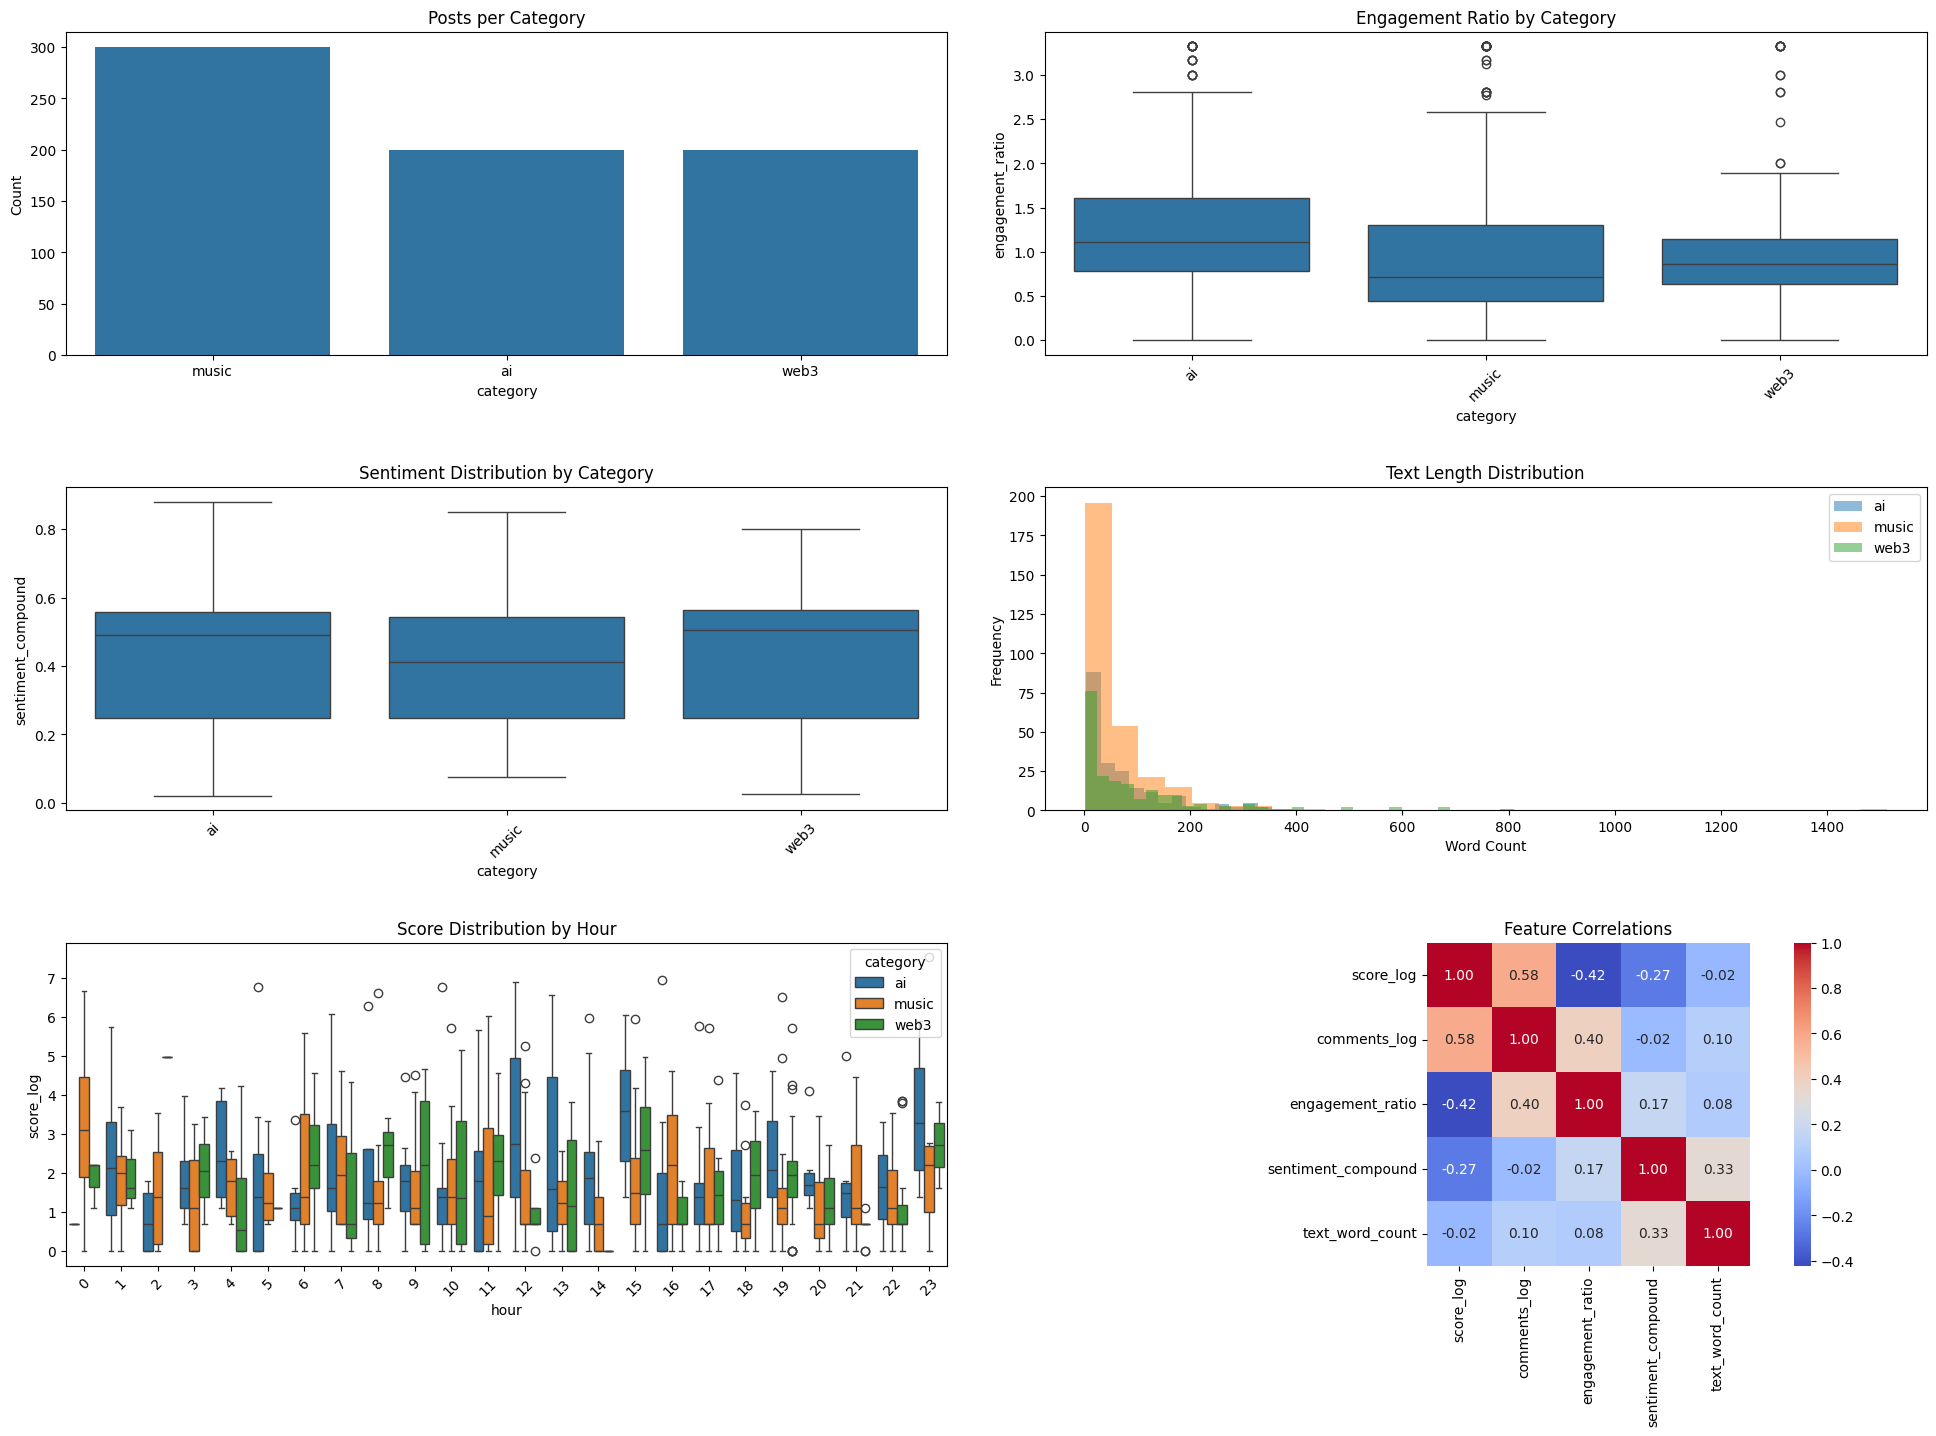


Model Performance:
              precision    recall  f1-score   support

          ai       0.88      0.70      0.78        40
       music       0.69      1.00      0.82        60
        web3       0.95      0.50      0.66        40

    accuracy                           0.77       140
   macro avg       0.84      0.73      0.75       140
weighted avg       0.82      0.77      0.76       140



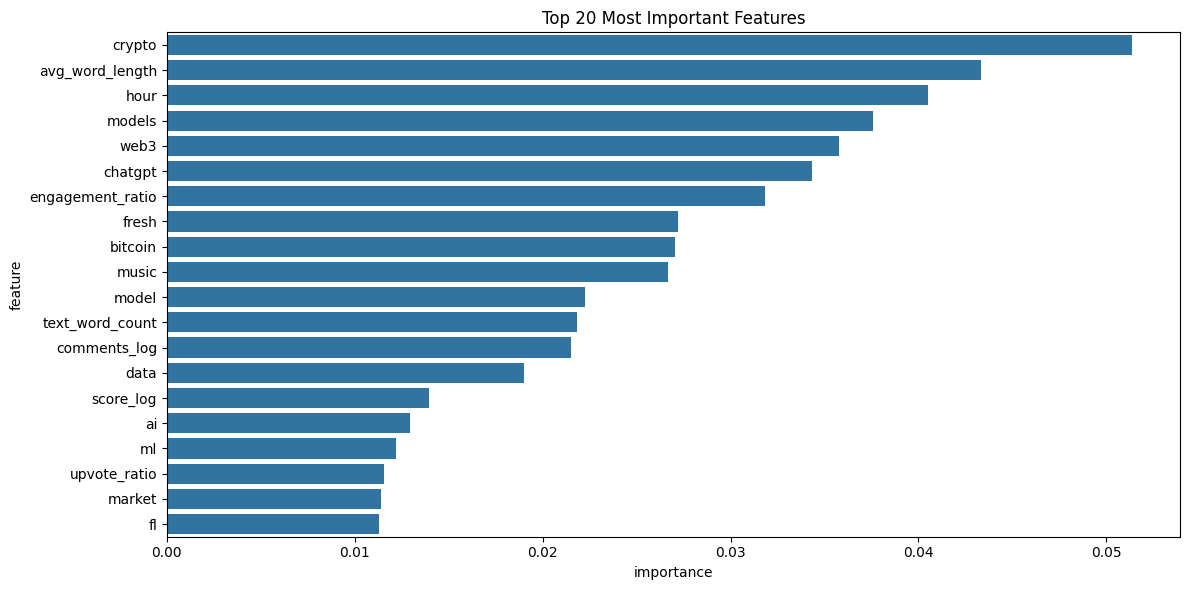


Data Processing Summary:
--------------------------------------------------
Total samples: 700
Features created: 986
Missing values remaining: 251
Text features: 977

Top 5 most important features:


,feature,importance
198,crypto,0.051353
5,avg_word_length,0.043320
7,hour,0.040498
563,models,0.037584
949,web3,0.035796


In [36]:
# Cell 1: Initial Setup and Imports
%cd /content
!rm -rf *  # Remove everything first
!git clone https://github.com/muhammmad-al/decentralized-ai-content-recommender.git
%cd decentralized-ai-content-recommender

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import logging
import warnings
from scipy import stats
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Cell 2: Data Loading and Initial Inspection
def load_data():
    """Load and combine datasets with error handling"""
    try:
        # Load individual datasets
        datasets = {
            'ai': pd.read_csv('data/raw/reddit_analysis_ai.csv'),
            'music': pd.read_csv('data/raw/reddit_analysis_music.csv'),
            'web3': pd.read_csv('data/raw/reddit_analysis_web3.csv')
        }

        # Add category labels
        for category, df in datasets.items():
            df['category'] = category

        # Combine datasets
        combined_data = pd.concat(datasets.values(), ignore_index=True)
        logger.info(f"Successfully loaded {len(combined_data)} records")

        return combined_data

    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

# Load data
df = load_data()

# Display basic information
print("\nDataset Overview:")
print(df.info())
print("\nSample Data:")
display(df.head())

# Cell 3: Data Cleaning and Preprocessing
class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy()
        self.numeric_features = ['score', 'num_comments', 'upvote_ratio',
                               'textblob_sentiment', 'transformer_score']

    def clean_text(self):
        """Clean and process text features"""
        # Fill missing text with titles
        self.df['cleaned_text'] = self.df['cleaned_text'].fillna(self.df['title'])

        # Create text quality indicators
        self.df['has_original_text'] = ~self.df['original_text'].isna()
        self.df['text_word_count'] = self.df['cleaned_text'].str.split().str.len()
        self.df['title_length'] = self.df['title'].str.len()

        return self

    def handle_missing_values(self):
        """Handle missing values in all columns"""
        # Handle numeric columns
        for col in ['account_age', 'author_karma']:
            self.df[col] = self.df[col].fillna(self.df[col].median())

        # Handle categorical columns
        self.df['author_verified'] = self.df['author_verified'].fillna('Unknown')

        return self

    def process_timestamps(self):
        """Process timestamp information"""
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df['hour'] = self.df['timestamp'].dt.hour
        self.df['day_of_week'] = self.df['timestamp'].dt.dayofweek
        self.df['is_weekend'] = self.df['day_of_week'].isin([5, 6]).astype(int)

        return self

    def create_engagement_features(self):
        """Create engagement-related features"""
        # Safe log transformation for engagement metrics
        self.df['score_log'] = np.log1p(self.df['score'])
        self.df['comments_log'] = np.log1p(self.df['num_comments'])

        # Create robust engagement ratio
        self.df['engagement_ratio'] = (np.log1p(self.df['num_comments']) /
                                     np.log1p(self.df['score'] + 1))

        # Cap extreme values
        self.df['engagement_ratio'] = self.df['engagement_ratio'].clip(
            upper=self.df['engagement_ratio'].quantile(0.95)
        )

        return self

    def add_text_features(self):
        """Add advanced text features"""
        # Basic text statistics
        self.df['avg_word_length'] = (self.df['cleaned_text'].str.len() /
                                    (self.df['text_word_count'] + 1))

        # Add sentiment features
        self.df['sentiment_compound'] = ((self.df['textblob_sentiment'] +
                                        (self.df['transformer_score'] * 2 - 1)) / 2)

        return self

    def remove_outliers(self, columns, n_std=3):
        """Remove extreme outliers from specified columns"""
        for col in columns:
            mean = self.df[col].mean()
            std = self.df[col].std()
            self.df[col] = self.df[col].clip(
                lower=mean - n_std * std,
                upper=mean + n_std * std
            )
        return self

    def process(self):
        """Execute all preprocessing steps"""
        return (self.clean_text()
                .handle_missing_values()
                .process_timestamps()
                .create_engagement_features()
                .add_text_features()
                .remove_outliers(self.numeric_features))

# Preprocess data
preprocessor = DataPreprocessor(df)
processed_df = preprocessor.process().df

# Cell 4: Feature Engineering and Selection
class FeatureEngineer:
    def __init__(self, df):
        self.df = df
        self.text_vectorizer = None
        self.feature_names = None

    def create_text_features(self, max_features=1000):
        """Create TF-IDF features from text"""
        self.text_vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            min_df=5
        )
        text_features = self.text_vectorizer.fit_transform(self.df['cleaned_text'])
        return text_features

    def get_numeric_features(self):
        """Get processed numeric features"""
        numeric_features = [
            'score_log', 'comments_log', 'engagement_ratio',
            'sentiment_compound', 'text_word_count', 'avg_word_length',
            'upvote_ratio', 'hour', 'is_weekend'
        ]
        return self.df[numeric_features]

    def prepare_features(self):
        """Prepare final feature matrix"""
        # Get numeric features
        numeric_features = self.get_numeric_features()

        # Get text features
        text_features = self.create_text_features()

        # Combine features
        X = np.hstack([
            numeric_features,
            text_features.toarray()
        ])

        # Store feature names
        self.feature_names = (
            list(numeric_features.columns) +
            list(self.text_vectorizer.get_feature_names_out())
        )

        return X, self.df['category']

# Create features
engineer = FeatureEngineer(processed_df)
X, y = engineer.prepare_features()

# Cell 5: Data Analysis and Visualization
def plot_data_analysis(df):
    """Create comprehensive data analysis plots"""
    # Set default matplotlib style instead of seaborn
    plt.style.use('default')

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))

    # 1. Category Distribution
    plt.subplot(3, 2, 1)
    category_counts = df['category'].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Posts per Category')
    plt.ylabel('Count')

    # 2. Engagement Metrics
    plt.subplot(3, 2, 2)
    sns.boxplot(data=df, x='category', y='engagement_ratio')
    plt.title('Engagement Ratio by Category')
    plt.xticks(rotation=45)

    # 3. Sentiment Distribution
    plt.subplot(3, 2, 3)
    sns.boxplot(data=df, x='category', y='sentiment_compound')
    plt.title('Sentiment Distribution by Category')
    plt.xticks(rotation=45)

    # 4. Text Length Distribution
    plt.subplot(3, 2, 4)
    for category in df['category'].unique():
        category_data = df[df['category'] == category]['text_word_count']
        plt.hist(category_data, bins=30, alpha=0.5, label=category)
    plt.title('Text Length Distribution')
    plt.legend()
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')

    # 5. Time Analysis
    plt.subplot(3, 2, 5)
    sns.boxplot(data=df, x='hour', y='score_log', hue='category')
    plt.title('Score Distribution by Hour')
    plt.xticks(rotation=45)

    # 6. Correlation Matrix
    plt.subplot(3, 2, 6)
    numeric_cols = ['score_log', 'comments_log', 'engagement_ratio',
                   'sentiment_compound', 'text_word_count']
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
                fmt='.2f', square=True)
    plt.title('Feature Correlations')

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=3.0)
    plt.show()

# Generate analysis plots
try:
    plot_data_analysis(processed_df)
except Exception as e:
    logger.error(f"Error in data visualization: {str(e)}")
    print("Visualization error occurred. Continuing with rest of processing...")
# Generate analysis plots
plot_data_analysis(processed_df)

# Cell 6: Model Preparation and Evaluation
def prepare_model_data(X, y, test_size=0.2):
    """Prepare data for modeling with proper scaling"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Scale numeric features
    scaler = RobustScaler()
    X_train[:, :9] = scaler.fit_transform(X_train[:, :9])
    X_test[:, :9] = scaler.transform(X_test[:, :9])

    return X_train, X_test, y_train, y_test

def train_and_evaluate_model(X_train, X_test, y_train, y_test, feature_names):
    """Train and evaluate the model"""
    # Train model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Get predictions
    y_pred = model.predict(X_test)

    # Print classification report
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importance = importance.sort_values('importance', ascending=False)

    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()

    return model, importance

# Prepare and evaluate model
X_train, X_test, y_train, y_test = prepare_model_data(X, y)
model, feature_importance = train_and_evaluate_model(
    X_train, X_test, y_train, y_test, engineer.feature_names
)

# Cell 7: Save Processed Data and Model
import joblib

def save_artifacts(model, preprocessor, engineer, processed_df):
    """Save model and preprocessing artifacts"""
    try:
        # Save model
        joblib.dump(model, 'model.joblib')

        # Save preprocessor and engineer
        joblib.dump(preprocessor, 'preprocessor.joblib')
        joblib.dump(engineer, 'engineer.joblib')

        # Save processed data
        processed_df.to_csv('processed_data.csv', index=False)

        logger.info("Successfully saved all artifacts")

    except Exception as e:
        logger.error(f"Error saving artifacts: {str(e)}")
        raise

# Save artifacts
save_artifacts(model, preprocessor, engineer, processed_df)

# Print final summary
print("\nData Processing Summary:")
print("-" * 50)
print(f"Total samples: {len(processed_df)}")
print(f"Features created: {X.shape[1]}")
print(f"Missing values remaining: {processed_df.isnull().sum().sum()}")
print(f"Text features: {X.shape[1] - 9}")
print("\nTop 5 most important features:")
display(feature_importance.head())